# Analytic Functions

Analytic functions allow us to perform complex calculations with relatively straightforward syntax. For instance, we can quickly calculate moving averages and running totals, among other quantities.

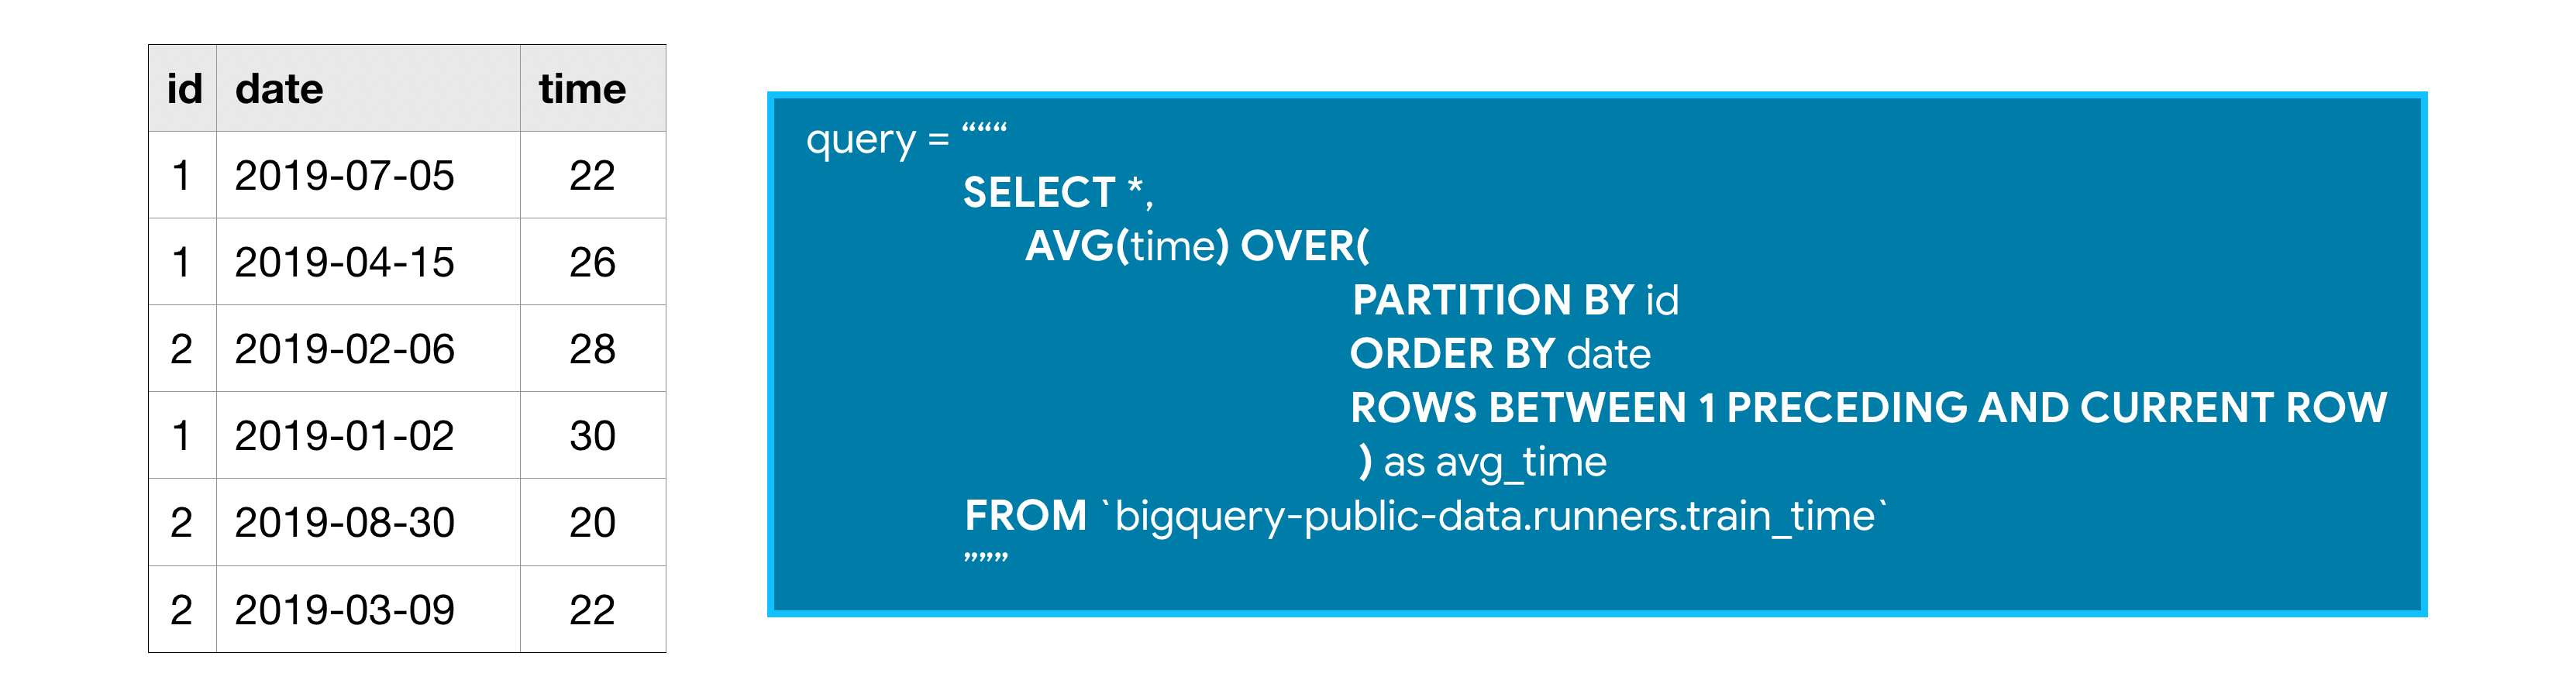

All analytic functions have an OVER clause, which defines the sets of rows used in each calculation. The OVER clause has three (optional) parts:

- The PARTITION BY clause divides the rows of the table into different groups. In the query above, we divide by id so that the calculations are separated by runner.
- The ORDER BY clause defines an ordering within each partition. In the sample query, ordering by the date column ensures that earlier training sessions appear first.
- The final clause (ROWS BETWEEN 1 PRECEDING AND CURRENT ROW) is known as a window frame clause. It identifies the set of rows used in each calculation. We can refer to this group of rows as a window. (Actually, analytic functions are sometimes referred to as analytic window functions or simply window functions!)

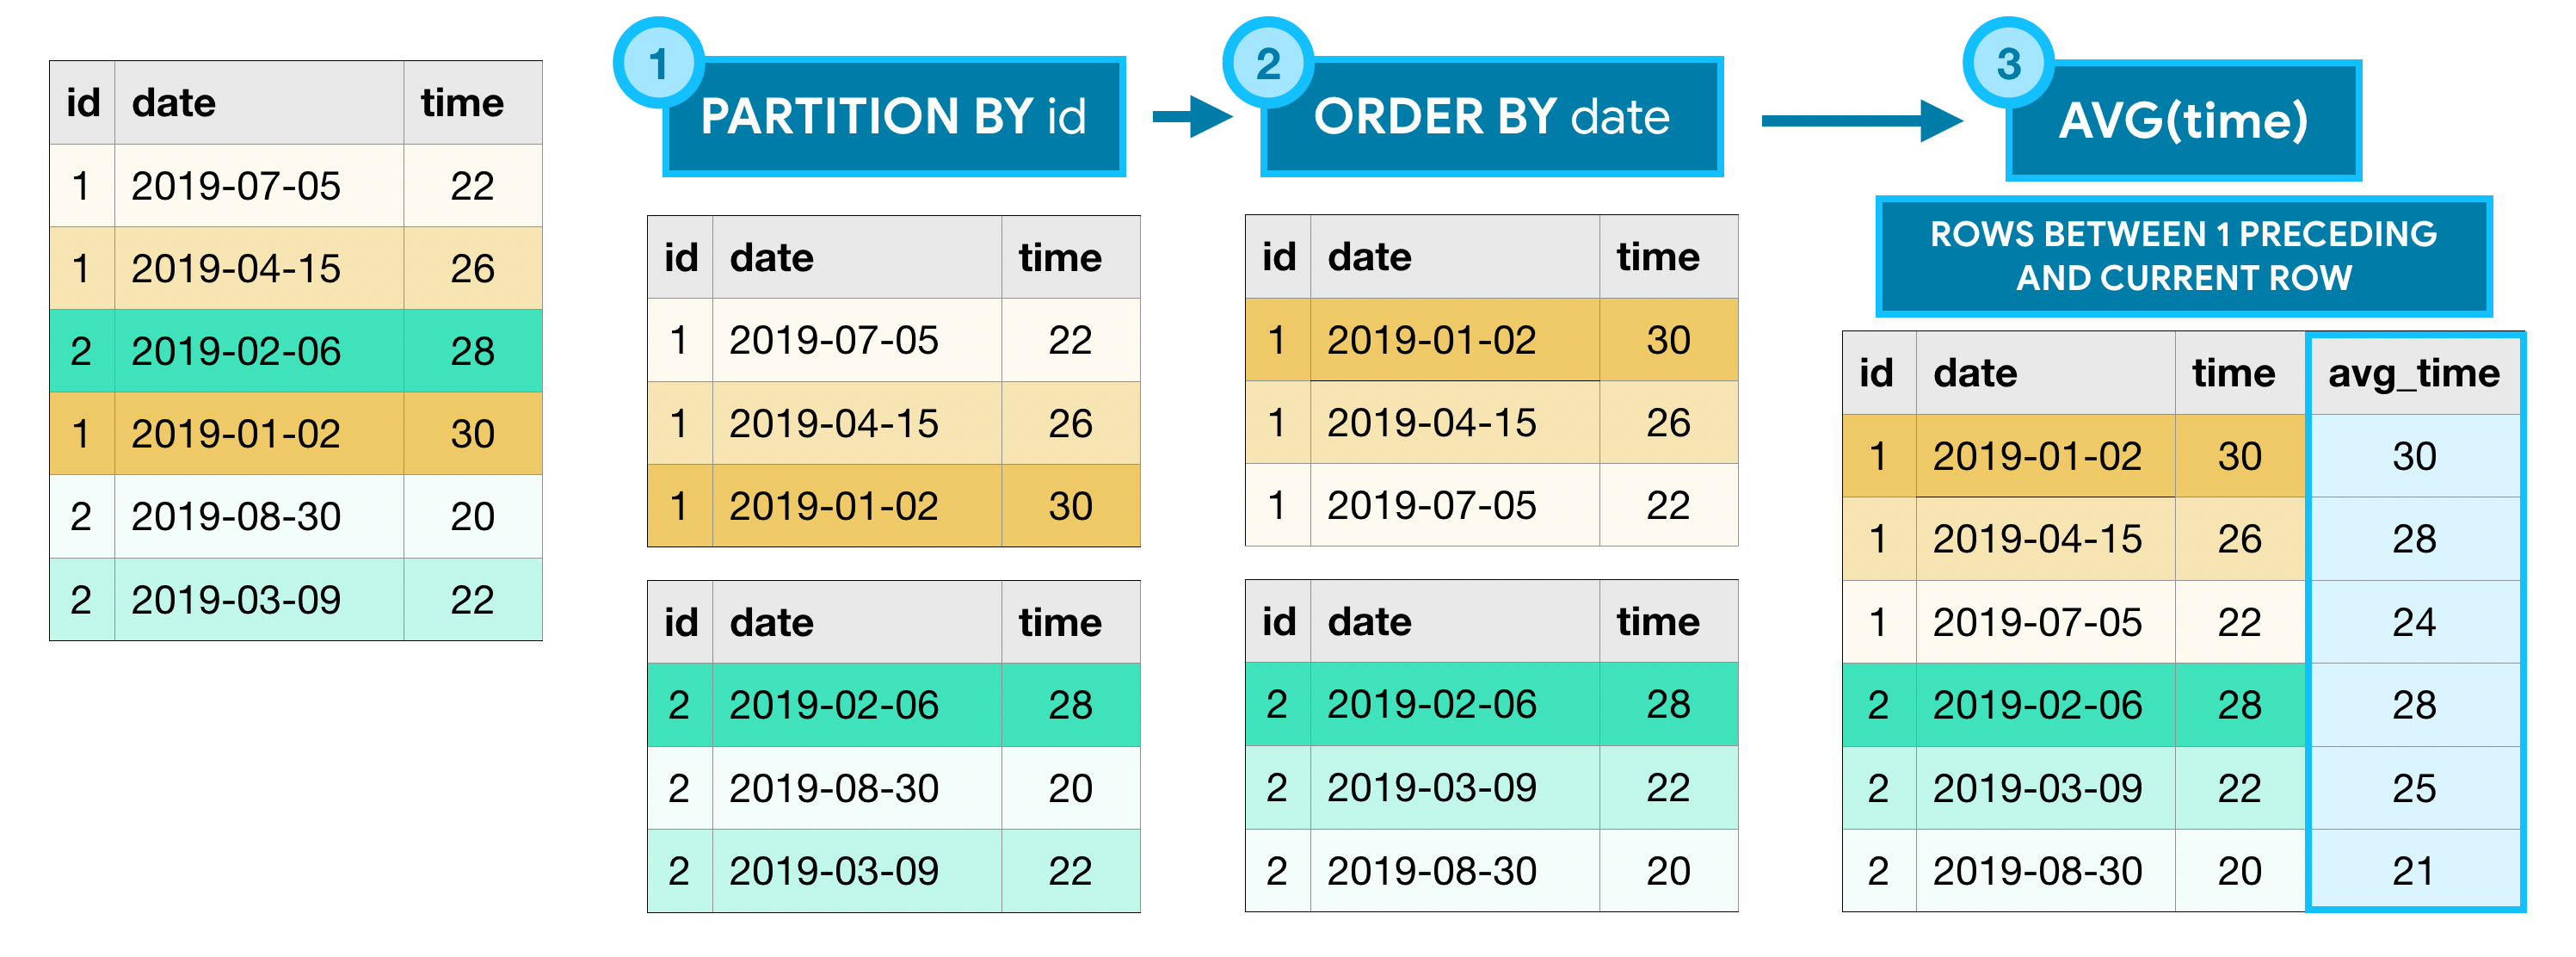

In [1]:
from google.cloud import bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="sql-bigquery-341310-10504b2450ab.json"
from bigquery_functions import *

# Create a "Client" object
client = bigquery.Client()

In [16]:
dataset_ref = list_dataset_tables(client, 'san_francisco')

311_service_requests
bikeshare_stations
bikeshare_status
bikeshare_trips
film_locations
sffd_service_calls
sfpd_incidents
street_trees


In [3]:
licenses_table = get_table(client, dataset_ref, 'bikeshare_trips')
client.list_rows(licenses_table, max_results=5).to_dataframe()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,944732,2618,2015-09-24 17:22:00+00:00,Mezes,83,2015-09-24 18:06:00+00:00,Mezes,83,653,94063,Customer
1,984595,5957,2015-10-25 18:12:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,52,nil,Customer
2,984596,5913,2015-10-25 18:13:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,121,nil,Customer
3,1129385,6079,2016-03-18 10:33:00+00:00,Mezes,83,2016-03-18 12:14:00+00:00,Mezes,83,208,94070,Customer
4,1030383,5780,2015-12-06 10:52:00+00:00,Mezes,83,2015-12-06 12:28:00+00:00,Mezes,83,44,94064,Customer


### 1) Analytic aggregate functions

- **MIN()** (or **MAX()**) - Returns the minimum (or maximum) of input values
- **AVG()** (or **SUM()**) - Returns the average (or sum) of input values
- **COUNT()** - Returns the number of rows in the input

### 2) Analytic navigation functions

- **FIRST_VALUE()** (or **LAST_VALUE()**) - Returns the first (or last) value in the input
- **LEAD()** (and **LAG()**) - Returns the value on a subsequent (or preceding) row

### 3) Analytic numbering functions

- **ROW_NUMBER()** - Returns the order in which rows appear in the input (starting with 1)
- **RANK()** - All rows with the same value in the ordering column receive the same rank value, where the next row receives a rank value which increments by the number of rows with the previous rank value.

In [4]:
# Query to count the (cumulative) number of trips per day
num_trips_query = """
                  WITH trips_by_day AS
                  (
                  SELECT DATE(start_date) AS trip_date,
                      COUNT(*) as num_trips
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE EXTRACT(YEAR FROM start_date) = 2015
                  GROUP BY trip_date
                  )
                  SELECT *,
                      SUM(num_trips) 
                          OVER (
                               ORDER BY trip_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                               ) AS cumulative_trips
                      FROM trips_by_day
                  """

In [5]:
# Run the query, and return a pandas DataFrame
num_trips_result = client.query(num_trips_query).result().to_dataframe()
num_trips_result.head()

,trip_date,num_trips,cumulative_trips
0,2015-01-01,181,181
1,2015-01-02,428,609
2,2015-01-03,283,892
3,2015-01-04,206,1098
4,2015-01-05,1186,2284


In [6]:
# Query to track beginning and ending stations on October 25, 2015, for each bike
start_end_query = """
                  SELECT bike_number,
                      TIME(start_date) AS trip_time,
                      FIRST_VALUE(start_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS first_station_id,
                      LAST_VALUE(end_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS last_station_id,
                      start_station_id,
                      end_station_id
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE DATE(start_date) = '2015-10-25' 
                  """

In [7]:
# Run the query, and return a pandas DataFrame
start_end_result = client.query(start_end_query).result().to_dataframe()
start_end_result.head()

,bike_number,trip_time,first_station_id,last_station_id,start_station_id,end_station_id
0,196,13:55:00,13,13,13,13
1,525,11:19:00,54,71,54,60
2,525,13:10:00,54,71,60,71
3,554,09:04:00,71,39,71,39
4,332,13:18:00,41,49,41,77


# Nested and Repeated Data

Consider the case where each pet can have multiple toys. In this case, to collapse this information into a single table, we need to leverage a different datatype. Each entry in a repeated field is an ARRAY, or an ordered list of (zero or more) values with the same datatype. For instance, the entry in the "Toys" column for Moon the Dog is [Frisbee, Bone, Rope], which is an ARRAY with three values. Now, what if pets can have multiple toys, and we'd like to keep track of both the name and type of each toy? In this case, we can make the "Toys" column both nested and repeated.

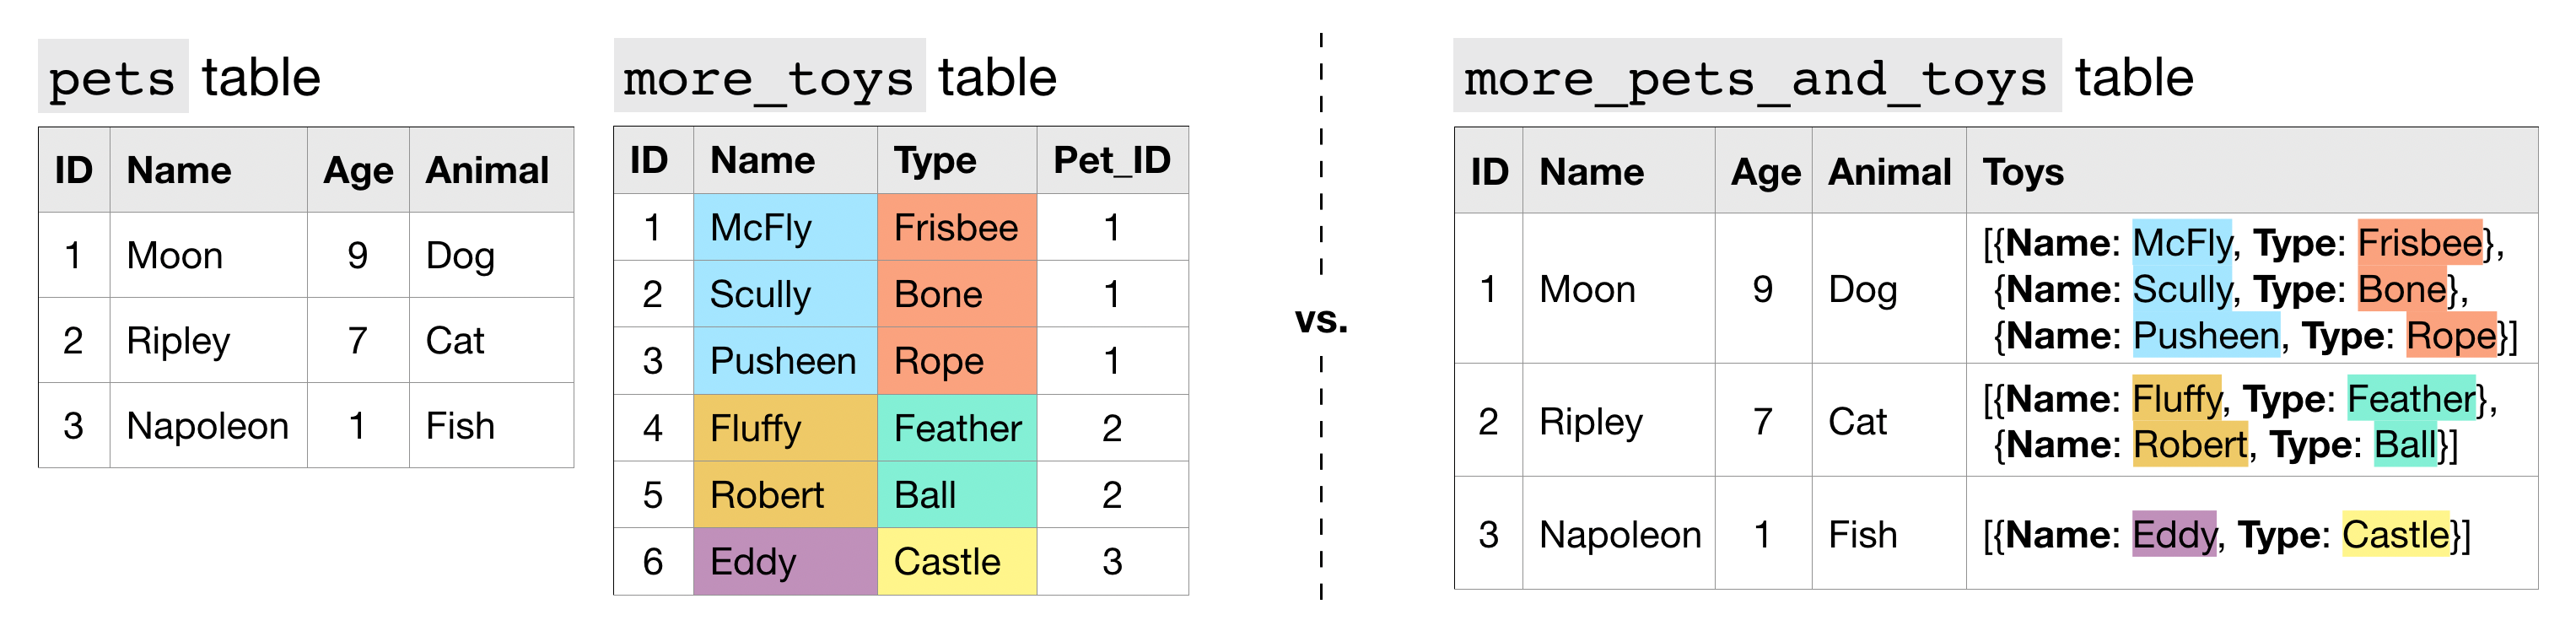

When querying repeated data, we need to put the name of the column containing the repeated data inside an UNNEST() function.
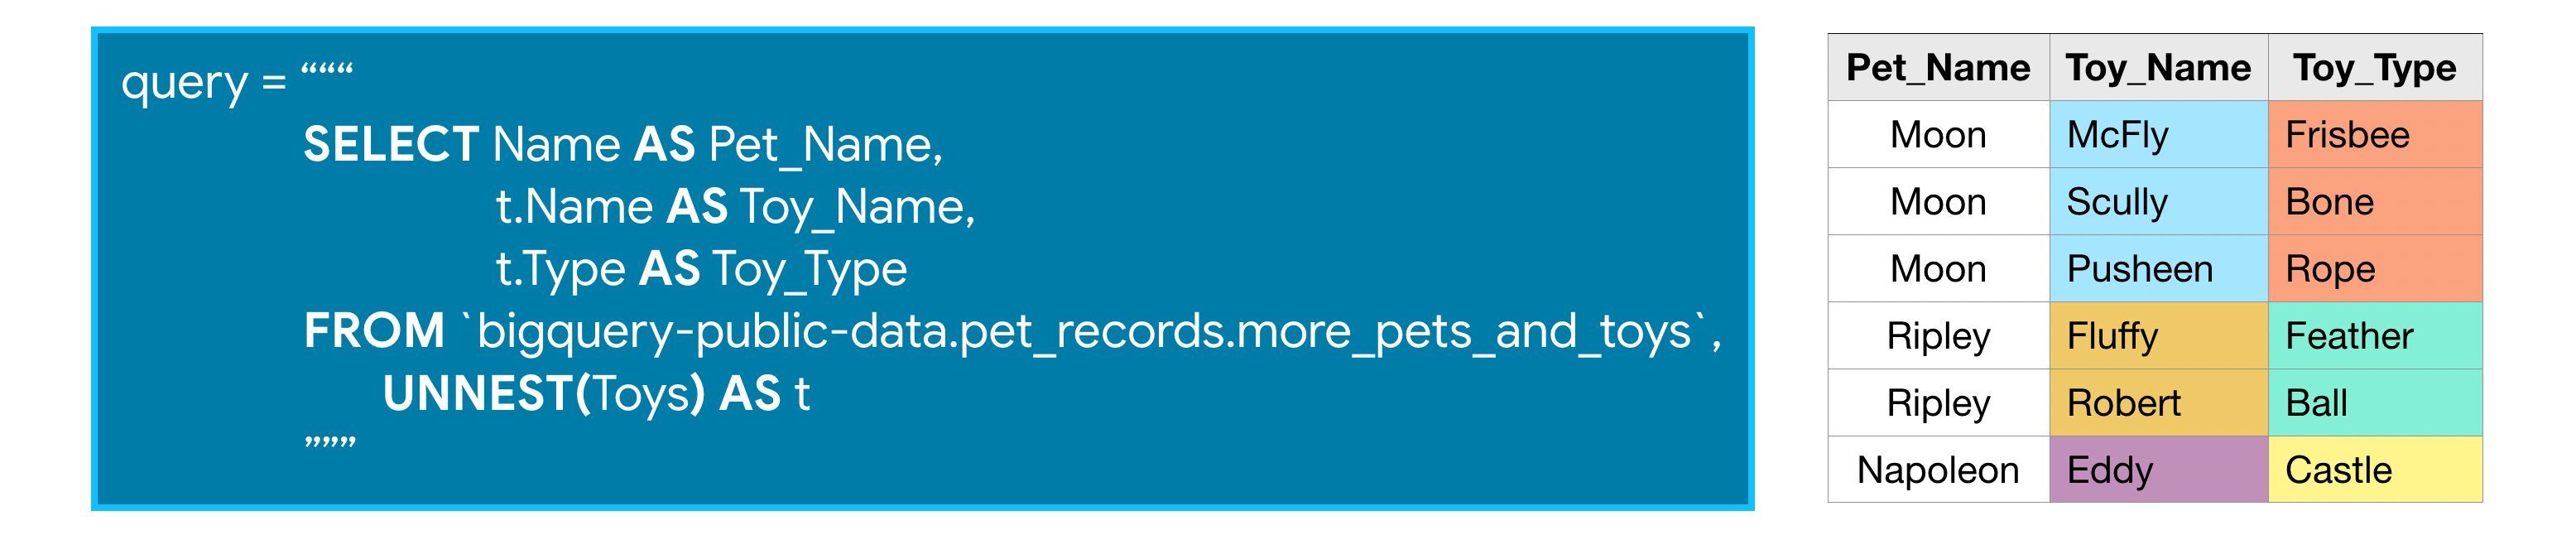

In [8]:
dataset_ref = list_dataset_tables(client, 'google_analytics_sample')

ga_sessions_20160801
ga_sessions_20160802
ga_sessions_20160803
ga_sessions_20160804
ga_sessions_20160805
ga_sessions_20160806
ga_sessions_20160807
ga_sessions_20160808
ga_sessions_20160809
ga_sessions_20160810
ga_sessions_20160811
ga_sessions_20160812
ga_sessions_20160813
ga_sessions_20160814
ga_sessions_20160815
ga_sessions_20160816
ga_sessions_20160817
ga_sessions_20160818
ga_sessions_20160819
ga_sessions_20160820
ga_sessions_20160821
ga_sessions_20160822
ga_sessions_20160823
ga_sessions_20160824
ga_sessions_20160825
ga_sessions_20160826
ga_sessions_20160827
ga_sessions_20160828
ga_sessions_20160829
ga_sessions_20160830
ga_sessions_20160831
ga_sessions_20160901
ga_sessions_20160902
ga_sessions_20160903
ga_sessions_20160904
ga_sessions_20160905
ga_sessions_20160906
ga_sessions_20160907
ga_sessions_20160908
ga_sessions_20160909
ga_sessions_20160910
ga_sessions_20160911
ga_sessions_20160912
ga_sessions_20160913
ga_sessions_20160914
ga_sessions_20160915
ga_sessions_20160916
ga_sessions_2

In [9]:
licenses_table = get_table(client, dataset_ref, 'ga_sessions_20170801')
client.list_rows(licenses_table, max_results=5).to_dataframe()

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,NaN,1,1501583974,1501583974,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Car...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2248281639583218707,None,None,Organic Search,Not Socially Engaged
1,NaN,1,1501616585,1501616585,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8647436381089107732,None,None,Organic Search,Not Socially Engaged
2,NaN,1,1501583344,1501583344,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2055839700856389632,None,None,Organic Search,Not Socially Engaged
3,NaN,1,1501573386,1501573386,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 0, 'minut...",0750846065342433129,None,None,Direct,Not Socially Engaged
4,NaN,8,1501651467,1501651467,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 22, 'minu...",0573427169410921198,None,None,Organic Search,Not Socially Engaged


In [10]:
# Query to count the number of transactions per browser
query = """
        SELECT device.browser AS device_browser,
            SUM(totals.transactions) as total_transactions
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
        GROUP BY device_browser
        ORDER BY total_transactions DESC
        """

In [11]:
result = client.query(query).result().to_dataframe()
result.head()

,device_browser,total_transactions
0,Chrome,41.0
1,Safari,3.0
2,Firefox,1.0
3,Internet Explorer,NaN
4,UC Browser,NaN


In [12]:
# Query to determine most popular landing point on the website
query = """
        SELECT hits.page.pagePath as path,
            COUNT(hits.page.pagePath) as counts
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`, 
            UNNEST(hits) as hits
        WHERE hits.type="PAGE" and hits.hitNumber=1
        GROUP BY path
        ORDER BY counts DESC
        """

In [13]:
result = client.query(query).result().to_dataframe()
result.head()

,path,counts
0,/home,1257
1,/google+redesign/shop+by+brand/youtube,587
2,/google+redesign/apparel/mens/mens+t+shirts,117
3,/signin.html,78
4,/basket.html,35


# Efficient Queries

## 1) Select only columns you want 

It is tempting to start queries with SELECT * FROM .... It's convenient because you don't need to think about which columns you need. But it can be very inefficient.

In [2]:
star_query = "SELECT * FROM `bigquery-public-data.github_repos.contents`"
show_amount_of_data_scanned(client, star_query)

basic_query = "SELECT size, binary FROM `bigquery-public-data.github_repos.contents`"
show_amount_of_data_scanned(client, basic_query)

Data processed: 2610.158 GB
Data processed: 2.471 GB


## 2) Read less Data

In [4]:
more_data_query = """
                  SELECT MIN(start_station_name) AS start_station_name,
                      MIN(end_station_name) AS end_station_name,
                      AVG(duration_sec) AS avg_duration_sec
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE start_station_id != end_station_id 
                  GROUP BY start_station_id, end_station_id
                  LIMIT 10
                  """
show_amount_of_data_scanned(client, more_data_query)

less_data_query = """
                  SELECT start_station_name,
                      end_station_name,
                      AVG(duration_sec) AS avg_duration_sec                  
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE start_station_name != end_station_name
                  GROUP BY start_station_name, end_station_name
                  LIMIT 10
                  """
show_amount_of_data_scanned(client, less_data_query)

Data processed: 0.076 GB
Data processed: 0.06 GB


## 3) Avoid N:N JOINs

In [ ]:
big_join_query = """
                 SELECT repo,
                     COUNT(DISTINCT c.committer.name) as num_committers,
                     COUNT(DISTINCT f.id) AS num_files
                 FROM `bigquery-public-data.github_repos.commits` AS c,
                     UNNEST(c.repo_name) AS repo
                 INNER JOIN `bigquery-public-data.github_repos.files` AS f
                     ON f.repo_name = repo
                 WHERE f.repo_name IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                 GROUP BY repo
                 ORDER BY repo
                 """
show_time_to_run(client, big_join_query)

small_join_query = """
                   WITH commits AS
                   (
                   SELECT COUNT(DISTINCT committer.name) AS num_committers, repo
                   FROM `bigquery-public-data.github_repos.commits`,
                       UNNEST(repo_name) as repo
                   WHERE repo IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                   GROUP BY repo
                   ),
                   files AS 
                   (
                   SELECT COUNT(DISTINCT id) AS num_files, repo_name as repo
                   FROM `bigquery-public-data.github_repos.files`
                   WHERE repo_name IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                   GROUP BY repo
                   )
                   SELECT commits.repo, commits.num_committers, files.num_files
                   FROM commits 
                   INNER JOIN files
                       ON commits.repo = files.repo
                   ORDER BY repo
                   """

show_time_to_run(client, small_join_query)